In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading dataset

In [7]:
ag_news_dataset = load_dataset("ag_news",
                               cache_dir = "/Data/pedro.silva/")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

In [9]:
data_size = len(ag_news_dataset['train'])
data_size

120000

In [10]:
train_text = ag_news_dataset['train']['text'][0:data_size*3//5]
train_labels = ag_news_dataset['train']['label'][0:data_size*3//5]

val_text = ag_news_dataset['train']['text'][data_size*3//5:]
val_labels = ag_news_dataset['train']['label'][data_size*3//5:]

## Analysis

In [14]:
model = SentenceTransformer(
    "peulsilva/phrase-bert-setfit-10shots",
    cache_folder = '/Data/pedro.silva',
    device=device
)

base_model = SentenceTransformer(
    "whaleloops/phrase-bert",
    cache_folder = '/Data/pedro.silva',
    device=device
)

In [15]:
from sklearn.decomposition import PCA

In [62]:
num_shots=  200
X, y = get_n_shots_per_class(
    val_text,
    val_labels,
    n_shots= num_shots,
    num_classes= num_classes
)

In [63]:
vectors = model.encode(X)
base_vectors = base_model.encode(X)

In [64]:
pca = PCA(n_components=3)
x1 = pca.fit_transform(vectors)
x2 = pca.fit_transform(base_vectors)



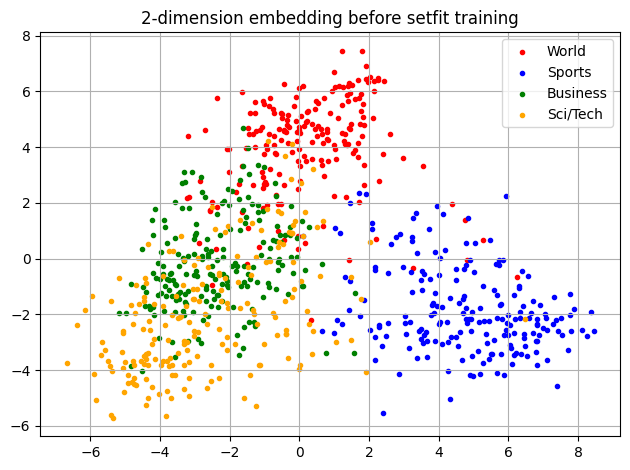

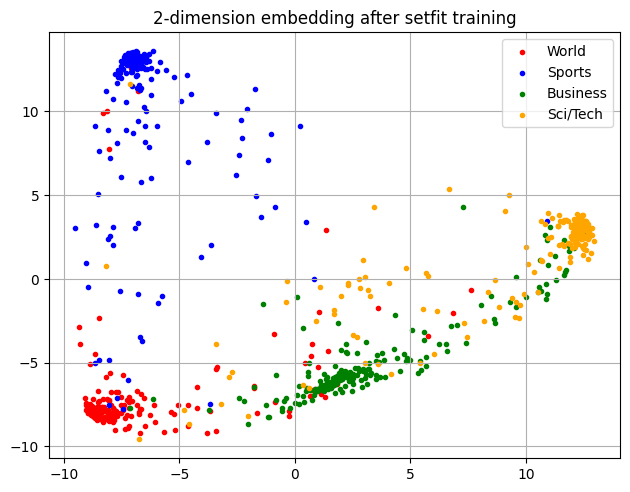

In [66]:
colors = ['red', 'blue', 'green', 'orange']
labels = ag_news_dataset['train'].features['label'].names

for c in range(num_classes):    
    
    plt.scatter(
        x2[c*num_shots: (c+1)*num_shots,0], 
        x2[c*num_shots: (c+1)*num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = labels[c]
    )

plt.legend()
plt.grid()
plt.title("2-dimension embedding before setfit training")
plt.tight_layout()
plt.show()

for c in range(num_classes):    
    
    plt.scatter(
        x1[c*num_shots: (c+1)*num_shots,0], 
        x1[c*num_shots: (c+1)*num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = labels[c]
    )

plt.legend()
plt.grid()
plt.tight_layout()
plt.title("2-dimension embedding after setfit training")
plt.show()

